,Month,Name,Demand
35,36,Dec,322.385076
36,37,Jan,237.951698
37,38,Feb,478.870715
38,39,Mar,629.901185
39,40,Apr,921.059310


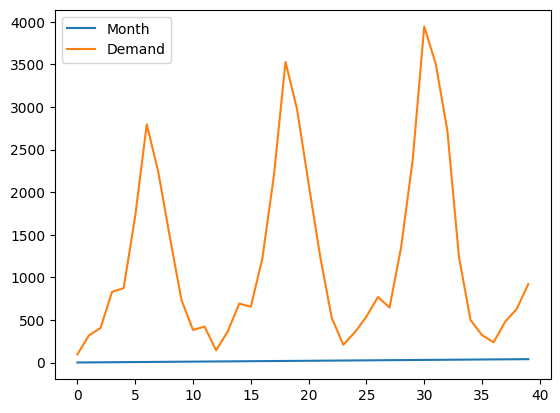

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

potting_soil = pd.read_excel('potting-soil.xlsx')
potting_soil.plot()
potting_soil.tail()

## 2.4

May forecast: 1320.4665922665517


<Axes: >

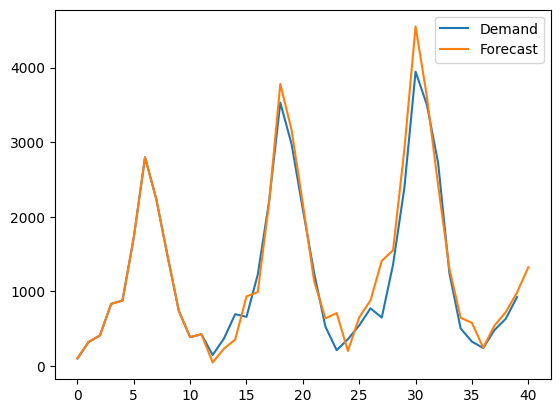

In [138]:
alpha = 0.2
beta = 0.1
gamma = 0.3

D = potting_soil["Demand"].to_numpy()

I = D[:12]
S = np.append(np.nan, D[1:12] - D[:11])
c = 12 * D[:12] / np.sum(D[:12])
y = D[:12]

for t in range(12, len(D)):
    # Add current months forcast to y
    y_t = (I[t - 1] + S[t - 1]) * c[t - 12]
    y = np.append(y, y_t)
    I_t = alpha * D[t] / c[t - 12] + (1 - alpha) * (I[t - 1] + S[t-1])
    I = np.append(I, I_t)
    S_t = beta * (I[t] - I[t-1]) + (1-beta) * S[t-1]
    S = np.append(S, S_t)
    c_t = gamma * D[t] / I[t] + (1 - gamma) * c[t - 12]
    c = np.append(c, c_t)


potting_soil["Forecast"] = y

t = len(D)
y_may = (I[t-1] + S[t - 1]) * c[t-12]
print(f"May forecast: {y_may}")

potting_soil_with_forecast = pd.concat([potting_soil, pd.DataFrame({"Demand": [np.nan], "Month": ["May"], "Forecast": [y_may]})], ignore_index=True)

potting_soil_with_forecast.plot()

## 2.6

<Axes: xlabel='Temp', ylabel='Demand'>

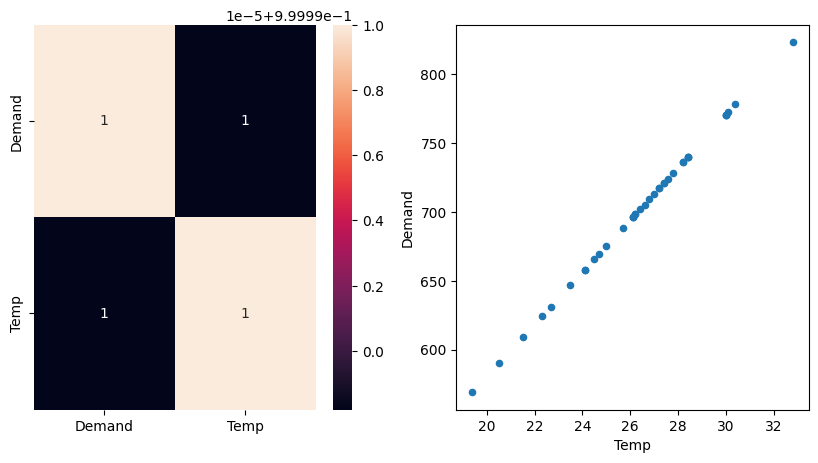

In [147]:
bottled_water = pd.read_excel('bottled-water.xlsx')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(bottled_water[["Demand", "Temp"]].corr(), annot=True, ax=ax[0]) # perfect correlation :)
bottled_water.plot.scatter(x="Temp", y="Demand", ax=ax[1])

beta_0: 200.73250873778284, beta_1: 18.977278276581348


<Axes: xlabel='Temp'>

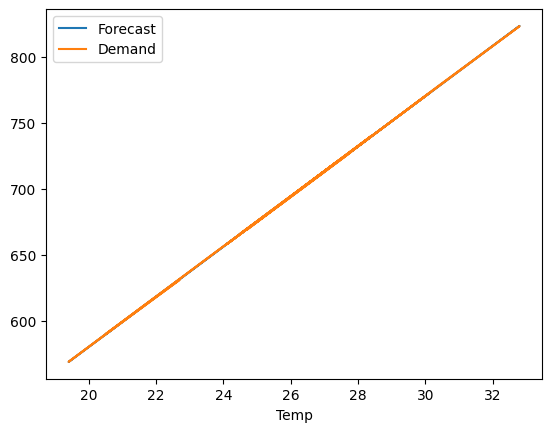

In [151]:
r_xy = np.corrcoef(bottled_water["Temp"], bottled_water["Demand"])[0, 1]
s_x = np.std(bottled_water["Temp"], ddof=1)
s_y = np.std(bottled_water["Demand"], ddof=1)
beta_1 = r_xy * s_y / s_x
beta_0 = np.mean(bottled_water["Demand"]) - beta_1 * np.mean(bottled_water["Temp"])
print(f"beta_0: {beta_0}, beta_1: {beta_1}")

bottled_water["Forecast"] = beta_0 + beta_1 * bottled_water["Temp"]
bottled_water[["Forecast", "Demand", "Temp"]].plot(x="Temp")

In [154]:
next_match_temps = np.array([21.6, 27.3, 26.6])
next_match_forecasts = beta_0 + beta_1 * next_match_temps
next_match_forecasts

array([610.64171951, 718.81220569, 705.52811089])

## 2.7

a) For the moving average we can simply use the concatenation of (D, y) for y so far. That is once we have $t$ that is greater than the length of $D$ we start using $y$.

b) Simply the same as above, instead of using only D we use y once we have run out of D.

c) Linear regression requires either observations, or a constant increase in time. Thus, no modification is needed as you can always model it to predict further into the future than one period. If it is an autoregressive linear regression you may simply do the same as above.

## 2.10

<Axes: >

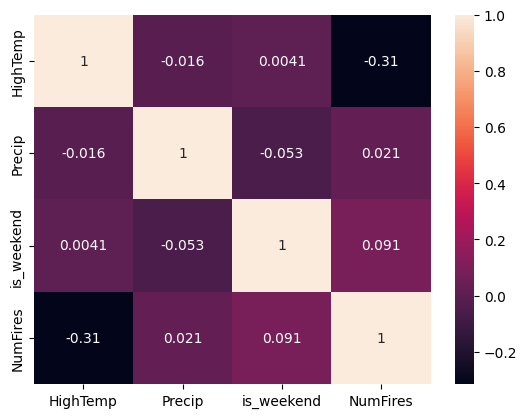

In [158]:
nyc_fires = pd.read_csv('nyc-fires.csv')
nyc_fires["Date"] = pd.to_datetime(nyc_fires["Date"])
nyc_fires["is_weekend"] = nyc_fires["Date"].dt.dayofweek >= 5
training = nyc_fires[nyc_fires["Date"] < "2016-01-01"]
testing = nyc_fires[nyc_fires["Date"] >= "2016-01-01"]
sns.heatmap(training[["HighTemp", "Precip", "is_weekend", "NumFires"]].corr(), annot=True)

In [159]:
# Linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(training[["HighTemp", "Precip", "is_weekend"]], training["NumFires"])
print(f"beta_0: {lr.intercept_}, beta_1: {lr.coef_}")

beta_0: 151.95028571427, beta_1: [-0.60891568  2.09061951  7.57444774]


Ellipsis

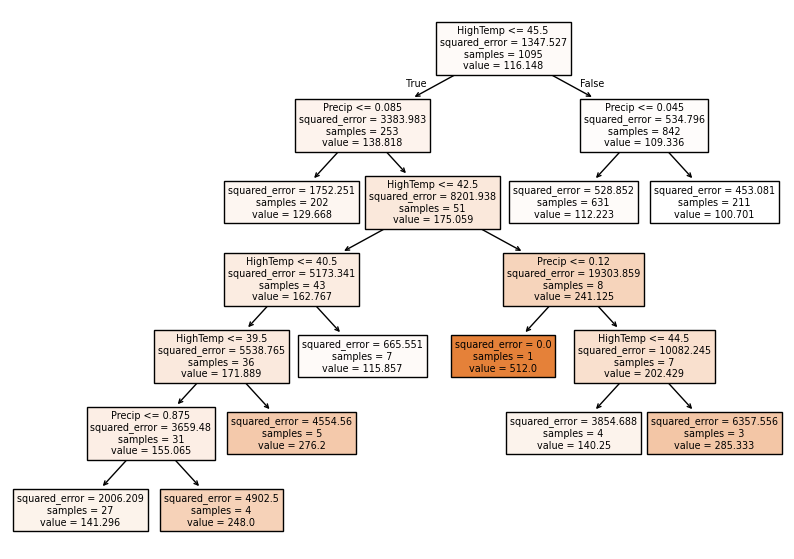

In [164]:
# Regression tree model with at most 10 branching nodes.
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
dtr = DecisionTreeRegressor(max_leaf_nodes=10)
dtr.fit(training[["HighTemp", "Precip", "is_weekend"]], training["NumFires"])
# Visualize the tree
fig, ax = plt.subplots(figsize=(10, 7))
plot_tree(dtr, feature_names=["HighTemp", "Precip", "is_weekend"], filled=True, ax=ax)
...

In [166]:
# SVR model
from sklearn.svm import SVR
svr = SVR(kernel="linear")
svr.fit(training[["HighTemp", "Precip", "is_weekend"]], training["NumFires"])
print(f"beta_0: {svr.intercept_}, beta_1: {svr.coef_}")

beta_0: [127.80228211], beta_1: [[-0.31890878 -1.69723435  7.46431269]]


In [176]:
from sklearn.metrics import mean_squared_error
lr_predictions = lr.predict(testing[["HighTemp", "Precip", "is_weekend"]])
dtr_predictions = dtr.predict(testing[["HighTemp", "Precip", "is_weekend"]])
svr_predictions = svr.predict(testing[["HighTemp", "Precip", "is_weekend"]])

lr_mse = mean_squared_error(testing["NumFires"], lr_predictions)
dtr_mse = mean_squared_error(testing["NumFires"], dtr_predictions)
svr_mse = mean_squared_error(testing["NumFires"], svr_predictions)

# Report the actual, predicted and forecast error for 10 first rows
values = {
    "Actual": testing["NumFires"].head(10),
    "Linear Regression": lr_predictions[:10],
    "Regression Tree": dtr_predictions[:10],
    "SVR": svr_predictions[:10]
}
df = pd.DataFrame(values)
df["LR Error"] = df["Actual"] - df["Linear Regression"]
df["DTR Error"] = df["Actual"] - df["Regression Tree"]
df["SVR Error"] = df["Actual"] - df["SVR"]
print(f"Mean squared error for linear regression: {lr_mse:.2f}")
print(f"Mean squared error for regression tree: {dtr_mse:.2f}")
print(f"Mean squared error for SVR: {svr_mse:.2f}")
df

Mean squared error for linear regression: 1090.01
Mean squared error for regression tree: 2352.02
Mean squared error for SVR: 1088.45


,Actual,Linear Regression,Regression Tree,SVR,LR Error,DTR Error,SVR Error
1095,142,126.375827,129.668317,114.408113,15.624173,12.331683,27.591887
1096,93,135.168106,129.668317,122.510244,-42.168106,-36.668317,-29.510244
1097,116,132.123528,129.668317,120.915700,-16.123528,-13.668317,-4.915700
1098,110,130.029321,129.668317,116.321566,-20.029321,-19.668317,-6.321566
1099,123,134.291731,129.668317,118.553927,-11.291731,-6.668317,4.446073
1100,123,126.984743,129.668317,114.727022,-3.984743,-6.668317,8.272978
1101,114,123.940164,112.223455,113.132478,-9.940164,1.776545,0.867522
1102,98,123.940164,112.223455,113.132478,-25.940164,-14.223455,-15.132478
1103,122,130.905697,112.223455,120.277882,-8.905697,9.776545,1.722118
1104,92,127.361823,100.701422,113.395955,-35.361823,-8.701422,-21.395955
